## Instruction
This tutorial delineates a computational framework for constructing gene regulatory networks (GRNs) from single-cell multiome data. We provide 2 options to do this: 'baseline' and 'LINGER'. The first is a naive method combining the prior GRNs and features from the single-cell data, offering a rapid approach. LINGER integrates the comprehensive gene regulatory profile from external bulk data. As the following figure, LINGER uses lifelong machine learning (continuous learning) based on neural network (NN) models, which has been proven to leverage the knowledge learned in previous tasks to help learn the new task better.  
本教程描述了从单细胞多组数据构建基因调控网络（GRN）的计算框架。我们提供了两种方法： 'baseline' “和 ”LINGER"。第一种是结合先验基因调控网络和单细胞数据特征的天真方法，提供了一种快速方法。LINGER 则从外部批量数据中整合了全面的基因调控概况。如下图所示，LINGER 使用基于神经网络（NN）模型的终身机器学习（持续学习），这种方法已被证明能利用在以前任务中学到的知识帮助更好地学习新任务。

After constructing the GRNs for cell population, we infer the cell type specific one using the feature engineering approach. Just as the following figure, we combine the single cell data ( O,E, and C in the figure) and the prior gene regulatory network structure with the parameter α,β,d,B, and γ.

## Download the general gene regulatory network
https://drive.google.com/file/d/1jwRgRHPJrKABOk7wImKONTtUupV7yJ9b/view?usp=sharing

## Prepare the input data
The input data is the feature matrix from 10x sc-multiome data and Cell annotation/cell type label which includes:输入数据要求 很重要

1. Single-cell multiome data including matrix.mtx.gz, features.tsv.gz, and barcodes.tsv.gz.
2. Cell annotation/cell type label if you need the cell type-specific gene regulatory network (PBMC_label.txt in our example).
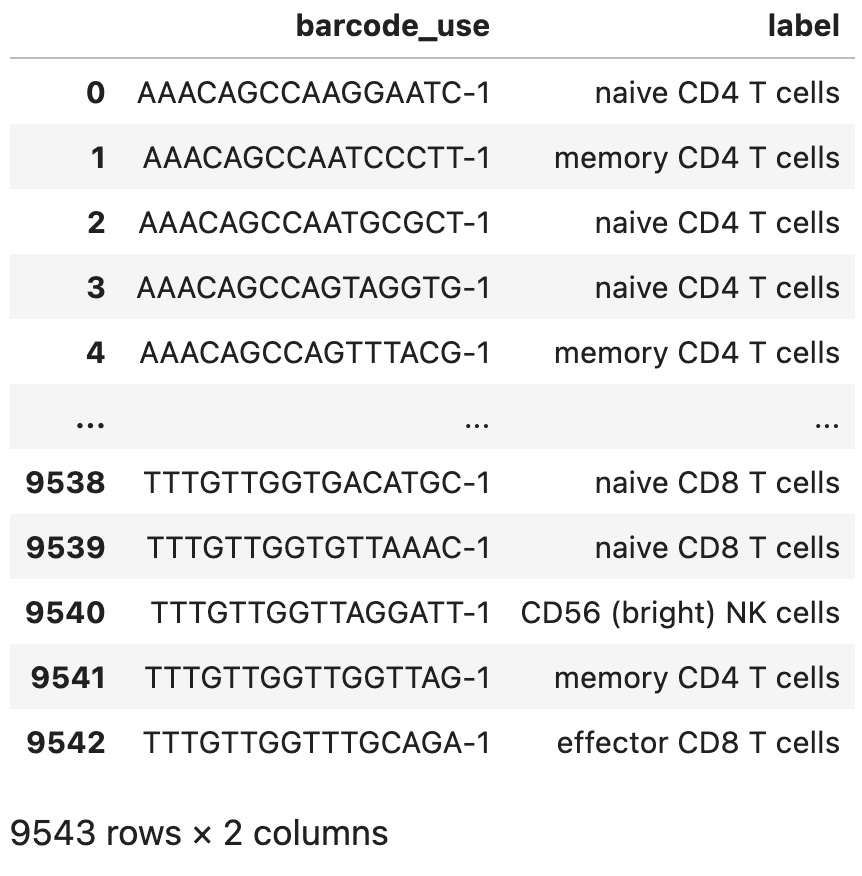

If the input data is 10X h5 file or h5ad file from scanpy, please follow the instruction h5/h5ad file as input .有另外一个教程文件

#### sc data

We provide the cell annotation as following:

## LINGER  
### install
略
### Preprocess
There are 2 options for the method we introduced above:

In [ ]:
#baseline;  
method='baseline' # this method is corresponding to bulkNN described in the paper

In [ ]:
#LINGER; 
method='LINGER'

### Transfer the sc-multiome data to anndata
We will transfer sc-multiome data to the anndata format and filter the cell barcode by the cell type label.

In [1]:
import scanpy as sc
#set some figure parameters for nice display inside jupyternotebooks.
%matplotlib inline
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(5, 5), facecolor='white')
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
#results_file = "scRNA/pbmc10k.h5ad"
import scipy
import pandas as pd
matrix=scipy.io.mmread('data/filtered_feature_bc_matrix/matrix.mtx')
features=pd.read_csv('data/filtered_feature_bc_matrix/features.tsv',sep='\t',header=None)
barcodes=pd.read_csv('data/filtered_feature_bc_matrix/barcodes.tsv',sep='\t',header=None)
label=pd.read_csv('data/PBMC_label.txt',sep='\t',header=0)
from LingerGRN.preprocess import *
adata_RNA,adata_ATAC=get_adata(matrix,features,barcodes,label)# adata_RNA and adata_ATAC are scRNA and scATAC

/disk1/cai026/mambaforge/envs/LINGER/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.5 anndata==0.9.2 umap==0.5.7 numpy==1.24.3 scipy==1.11.3 pandas==2.0.3 scikit-learn==1.3.0 statsmodels==0.14.1 pynndescent==0.5.13


FileNotFoundError: [Errno 2] No such file or directory: 'data/PBMC_label.txt'

### Remove low counts cells and genes

In [ ]:
import scanpy as sc
sc.pp.filter_cells(adata_RNA, min_genes=200)
sc.pp.filter_genes(adata_RNA, min_cells=3)
sc.pp.filter_cells(adata_ATAC, min_genes=200)
sc.pp.filter_genes(adata_ATAC, min_cells=3)
selected_barcode=list(set(adata_RNA.obs['barcode'].values)&set(adata_ATAC.obs['barcode'].values))
barcode_idx=pd.DataFrame(range(adata_RNA.shape[0]), index=adata_RNA.obs['barcode'].values)
adata_RNA = adata_RNA[barcode_idx.loc[selected_barcode][0]]
barcode_idx=pd.DataFrame(range(adata_ATAC.shape[0]), index=adata_ATAC.obs['barcode'].values)
adata_ATAC = adata_ATAC[barcode_idx.loc[selected_barcode][0]]

### Generate the pseudo-bulk/metacell:

In [ ]:
from LingerGRN.pseudo_bulk import *
samplelist=list(set(adata_ATAC.obs['sample'].values)) # sample is generated from cell barcode 
tempsample=samplelist[0]
TG_pseudobulk=pd.DataFrame([])
RE_pseudobulk=pd.DataFrame([])
singlepseudobulk = (adata_RNA.obs['sample'].unique().shape[0]*adata_RNA.obs['sample'].unique().shape[0]>100)
for tempsample in samplelist:
    adata_RNAtemp=adata_RNA[adata_RNA.obs['sample']==tempsample]
    adata_ATACtemp=adata_ATAC[adata_ATAC.obs['sample']==tempsample]
    TG_pseudobulk_temp,RE_pseudobulk_temp=pseudo_bulk(adata_RNAtemp,adata_ATACtemp,singlepseudobulk)                
    TG_pseudobulk=pd.concat([TG_pseudobulk, TG_pseudobulk_temp], axis=1)
    RE_pseudobulk=pd.concat([RE_pseudobulk, RE_pseudobulk_temp], axis=1)
    RE_pseudobulk[RE_pseudobulk > 100] = 100

import os
if not os.path.exists('data/'):
    os.mkdir('data/')
adata_ATAC.write('data/adata_ATAC.h5ad')
adata_RNA.write('data/adata_RNA.h5ad')
TG_pseudobulk=TG_pseudobulk.fillna(0)
RE_pseudobulk=RE_pseudobulk.fillna(0)
pd.DataFrame(adata_ATAC.var['gene_ids']).to_csv('data/Peaks.txt',header=None,index=None)
TG_pseudobulk.to_csv('data/TG_pseudobulk.tsv')
RE_pseudobulk.to_csv('data/RE_pseudobulk.tsv')

## Training model
Overlap the region with general GRN:

In [ ]:
from LingerGRN.preprocess import *
Datadir='/path/to/LINGER/'# This directory should be the same as Datadir defined in the above 'Download the general gene regulatory network' section
GRNdir=Datadir+'data_bulk/'
genome='hg38'
outdir='/path/to/output/' #output dir
preprocess(TG_pseudobulk,RE_pseudobulk,GRNdir,genome,method,outdir)
#注意了 就是这一步将下载的bulk测序数据运用起来 生成文章里面说的GRN（TF-RE motif matching）
#如果是我 是否可以将这些bulk测序数据换成MDS的BULK数据

Train for the LINGER model.

In [ ]:
import LingerGRN.LINGER_tr as LINGER_tr
activef='ReLU' # active function chose from 'ReLU','sigmoid','tanh'
LINGER_tr.training(GRNdir,method,outdir,activef,'Human')

### Cell population gene regulatory network
细胞群

**TF binding potential**  
The output is 'cell_population_TF_RE_binding.txt', a matrix of the TF-RE binding score.

In [ ]:
import LingerGRN.LL_net as LL_net
LL_net.TF_RE_binding(GRNdir,adata_RNA,adata_ATAC,genome,method,outdir)

**cis-regulatory network**  
The output is 'cell_population_cis_regulatory.txt' with 3 columns: region, target gene, cis-regulatory score.

In [ ]:
LL_net.cis_reg(GRNdir,adata_RNA,adata_ATAC,genome,method,outdir)

**trans-regulatory network**  
The output is 'cell_population_trans_regulatory.txt', a matrix of the trans-regulatory score.

In [ ]:
LL_net.trans_reg(GRNdir,method,outdir,genome)

### Cell type sepecific gene regulaory network
特定细胞类型
There are 2 options:

1. infer GRN for a specific cell type, which is in the label.txt;

In [ ]:
celltype='CD56 (bright) NK cells' #use a string to assign your cell type

2. infer GRNs for all cell types.

In [ ]:
celltype='all'

Please make sure that 'all' is not a cell type in your data.

**TF binding potential**  
The output is 'cell_population_TF_RE_binding_celltype.txt', a matrix of the TF-RE binding potential.

In [ ]:
LL_net.cell_type_specific_TF_RE_binding(GRNdir,adata_RNA,adata_ATAC,genome,celltype,outdir,method)# different from the previous version

**cis-regulatory network**  
The output is 'cell_type_specific_cis_regulatory_{celltype}.txt' with 3 columns: region, target gene, cis-regulatory score.

In [ ]:
LL_net.cell_type_specific_cis_reg(GRNdir,adata_RNA,adata_ATAC,genome,celltype,outdir)

**trans-regulatory network**  
The output is 'cell_type_specific_trans_regulatory_{celltype}.txt', a matrix of the trans-regulatory score.

In [ ]:
LL_net.cell_type_specific_trans_reg(GRNdir,adata_RNA,celltype,outdir)

## Identify driver regulators by TF activity
下游应用
### Instruction
TF activity, focusing on the DNA-binding component of TF proteins in the nucleus, is a more reliable metric than mRNA or whole protein expression for identifying driver regulators. Here, we employed LINGER inferred GRNs from sc-multiome data of a single individual. Assuming the GRN structure is consistent across individuals, we estimated TF activity using gene expression data alone. By comparing TF activity between cases and controls, we identified driver regulators.  
与 mRNA 或整个蛋白质的表达相比，TF 活性是识别驱动调节因子的一个更可靠的指标。在这里，我们利用 LINGER 从单个个体的 sc-multiome 数据中推断出 GRN。假定不同个体的 GRN 结构是一致的，我们仅使用基因表达数据来估计 TF 活性。通过比较病例和对照组的 TF 活性，我们确定了驱动调节因子。

### Prepare
We need to trans-regulatory network, you can choose a network match you data best.

1. If there is not single cell avaliable to infer the cell population and cell type specific GRN, you can choose a GRN from various tissues.

In [ ]:
network = 'general'

2. If your gene expression data are matched with cell population GRN, you can set

In [ ]:
network = 'cell population'

3. If your gene expression data are matched with certain cell type, you can set network to the name of this cell type.

In [2]:
network = 'CD56 (bright) NK cells' # CD56 (bright) NK cells is the name of one cell type

### Calculate TF activity  
The input is gene expression data, It could be the scRNA-seq data from the sc multiome data. It could be other sc or bulk RNA-seq data matches the GRN. The row of gene expresion data is gene, columns is sample and the value is read count (sc) or FPKM/RPKM (bulk).  
输入是基因表达数据，可以是 sc 多组数据中的 scRNA-seq 数据。也可能是与 GRN 匹配的其他 sc 或批量 RNA-seq 数据。基因表达数据的行为基因，列为样本，值为读数（sc）或 FPKM/RPKM（bulk）。

In [ ]:
Datadir='/zfs/durenlab/palmetto/Kaya/SC_NET/code/github/combine/'# this directory should be the same with Datadir
GRNdir=Datadir+'data_bulk/'
genome='hg38'
from LingerGRN.TF_activity import *
outdir='/zfs/durenlab/palmetto/Kaya/SC_NET/code/github/combine/LINGER/examples/output/' #output dir
import anndata
adata_RNA=anndata.read_h5ad('data/adata_RNA.h5ad')
TF_activity=regulon(outdir,adata_RNA,GRNdir,network,genome)

Visualize the TF activity heatmap by cluster. If you want to save the heatmap to outdit, please set 'save=True'. The output is 'heatmap_activity.png'.

In [ ]:
save=True
heatmap_cluster(TF_activity,adata_RNA,save,outdir)

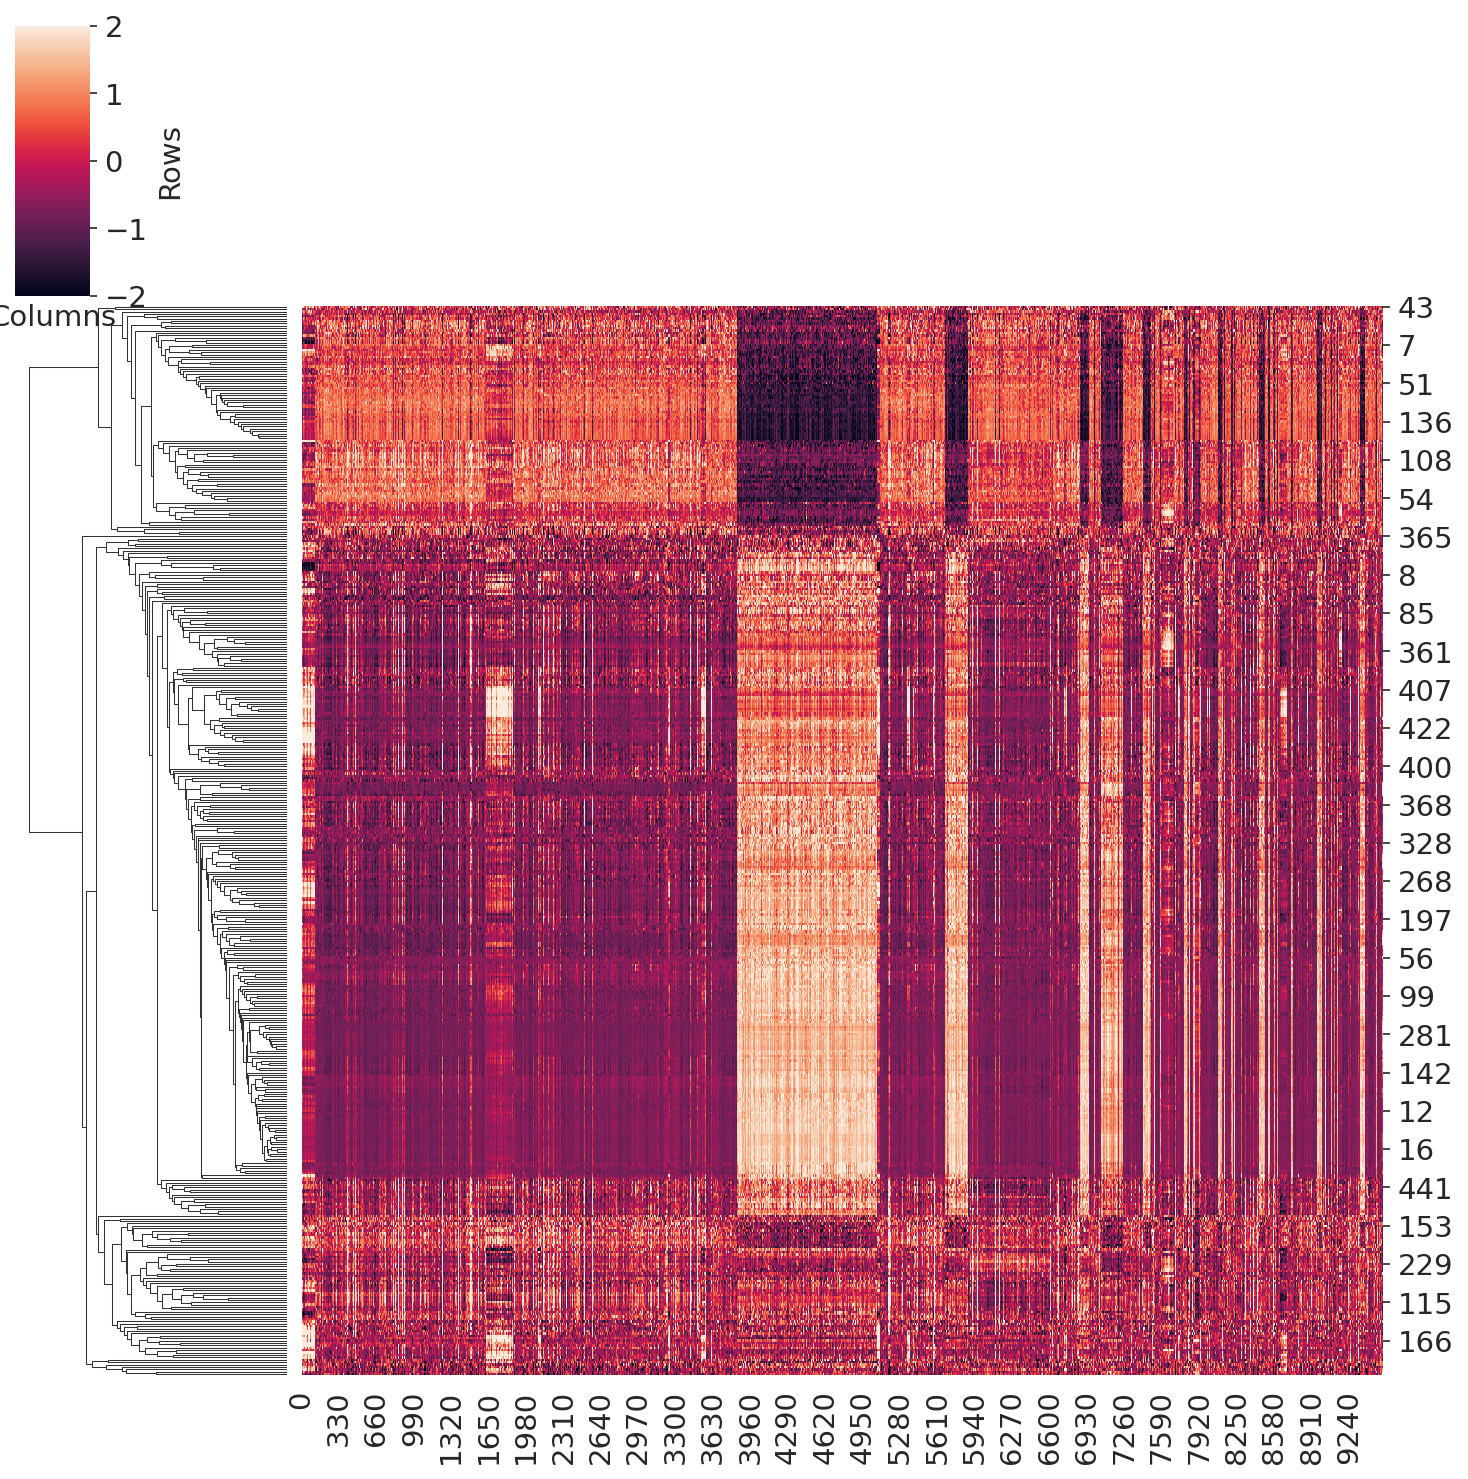

## Identify driver regulator
We use t-test to find the differential TFs of a certain cell type by the activity.

1. You can assign a certain cell type of the gene expression data by

In [ ]:
celltype='CD56 (bright) NK cells'

2. Or, you can obtain the result for all cell types.

In [ ]:
celltype='all'

For example,

In [ ]:
celltype='CD56 (bright) NK cells'
t_test_results=master_regulator(TF_activity,adata_RNA,celltype)
t_test_results

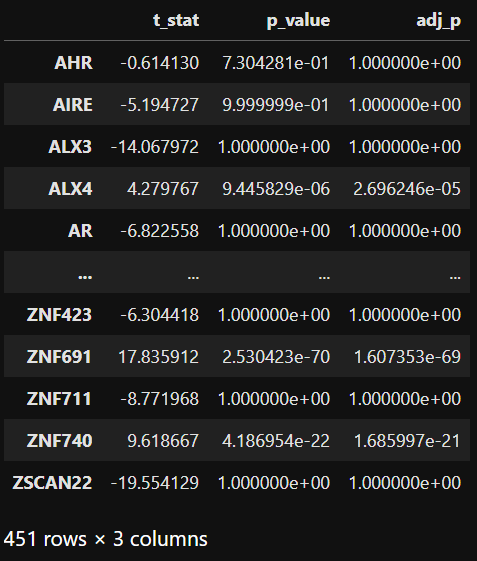

Visulize the differential activity and expression. You can compare 2 different cell types and one cell type with other cell types. If you want to save the heatmap to outdit, please set 'save=True'. The output is 'box_plot'+TFName+''+datatype+''+celltype1+''+celltype2+'.png'.  
细胞类型间比较

In [ ]:
TFName='ATF1'
datatype='activity'
celltype1='CD56 (bright) NK cells'
celltype2='Others'
save=True
box_comp(TFName,adata_RNA,celltype1,celltype2,datatype,TF_activity,save,outdir)

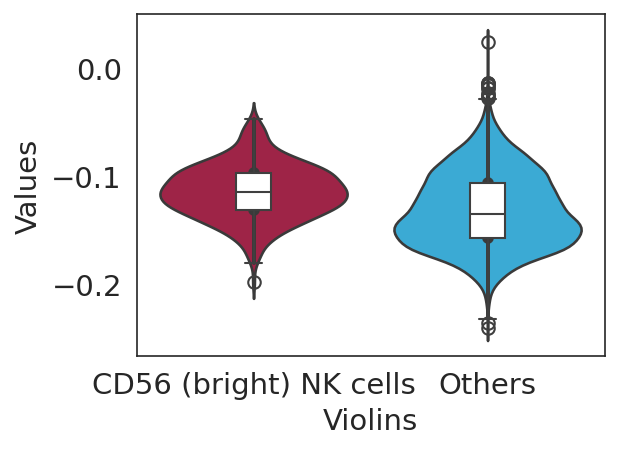

For gene expression data, the boxplot is:

In [ ]:
datatype='expression'
box_comp(TFName,adata_RNA,celltype1,celltype2,datatype,TF_activity,save,outdir)

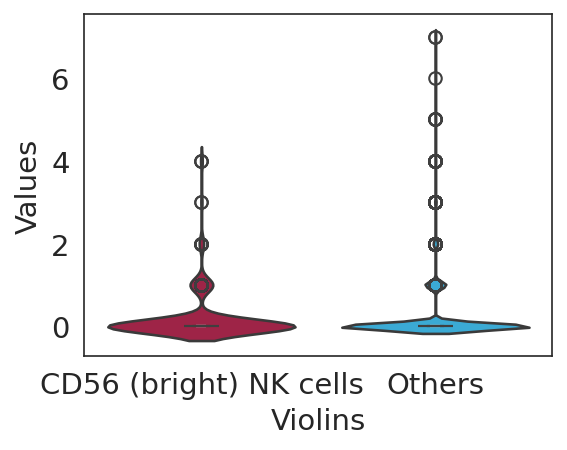

## Note
1. The cell specific GRN is based on the output of the cell population GRN.
2. If we want to try 2 different method options, we can create 2 output directory.